# 1. 데이터 준비

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
x_data = pd.read_csv('/content/x_data.csv', index_col=0)

In [ ]:
import pickle

In [ ]:
with open(r'/content/data_y.pkl', 'rb') as f:
    y_data = pickle.load(f)

In [ ]:
# 데이터 분포
y_data.count(0), y_data.count(1), y_data.count(2)

(67, 67, 68)

In [ ]:
x_data = np.array(x_data)
y_data = np.array(y_data)

y_data_onehot = np.array(pd.get_dummies(y_data))

In [ ]:
len(x_data[0]), len(y_data_onehot)

(20, 202)

# 1.1 train test 분리
80:20

In [ ]:
from sklearn.model_selection import train_test_split

# 분리할 때 20프로, in out nothing 고루 섞이게 stratify 진행
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data_onehot, test_size=0.2, shuffle=True, stratify=y_data_onehot, random_state=34)

In [ ]:
x_train.shape, x_test.shape

((161, 20), (41, 20))

# 2. 기본 RNN 모델

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from tensorflow.keras import Sequential

from keras.layers import Dropout

In [ ]:
# 모델 설정
model = Sequential()
model.add(SimpleRNN(units=256, activation='tanh', input_shape=(20,1)))
model.add(Dense(3, activation='softmax'))

In [ ]:
# RNN 레이어 1, FC 레이어 1
model.summary()

Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_124 (SimpleRNN)  (None, 256)               66048     
                                                                 
 dense_102 (Dense)           (None, 3)                 771       
                                                                 
Total params: 66,819
Trainable params: 66,819
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델의 실행 옵션

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# 모델 저장 조건 설정
modelpath = 'RNN_1.hdf5'
checkpointer=ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
 
# 학습 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

## 73% 정확도 (test_accuracy)

In [ ]:
# 모델 실행 (양이 많지 않으므로 배치 크기 1)
history = model.fit(x_train, y_train, batch_size=1, epochs=50,
                    validation_data = (x_test, y_test), callbacks=[checkpointer, early_stopping_callback])
# 결과 출력
print("\n Accuracy : %.4f" %(model.evaluate(x_train,y_train)[1]))

Epoch 1/50
157/161 [============================>.] - ETA: 0s - loss: 0.9118 - accuracy: 0.5987
Epoch 1: val_loss improved from inf to 0.67795, saving model to RNN_1.hdf5
161/161 [==============================] - 2s 9ms/step - loss: 0.9169 - accuracy: 0.5901 - val_loss: 0.6780 - val_accuracy: 0.5366
Epoch 2/50
155/161 [===========================>..] - ETA: 0s - loss: 0.9162 - accuracy: 0.5484
Epoch 2: val_loss improved from 0.67795 to 0.62574, saving model to RNN_1.hdf5
161/161 [==============================] - 1s 7ms/step - loss: 0.9072 - accuracy: 0.5466 - val_loss: 0.6257 - val_accuracy: 0.6341
Epoch 3/50
155/161 [===========================>..] - ETA: 0s - loss: 0.8951 - accuracy: 0.5290
Epoch 3: val_loss did not improve from 0.62574
161/161 [==============================] - 1s 7ms/step - loss: 0.8889 - accuracy: 0.5342 - val_loss: 0.7082 - val_accuracy: 0.6585
Epoch 4/50
156/161 [============================>.] - ETA: 0s - loss: 0.7759 - accuracy: 0.6218
Epoch 4: val_loss impr

KeyboardInterrupt: ignored

In [ ]:
# 이런 식으로 학습
model.predict(x_train[0].reshape(1,20,1))

1/1 [==============================] - 0s 133ms/step


array([[0.2055003 , 0.5522169 , 0.24228282]], dtype=float32)

# 3. 모델 개선

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from tensorflow.keras import Sequential

from keras.layers import Dropout

## 변경 기록
1. unit 수 감소 (256에서 128로) 63% ->256이 최적
2. optimizer 비교 했을 때 sgd 보다는 adam 이 준수함
3. fc 레이어 층 하나 추가 (레이어 100, ReLU) ->33%
4. fc 레이어 층 하나 추가 (레이어 100, tanh) ->63%   // 그나마 tanh
5. fc 레이어 층 하나 추가 (레이어 50, tanh) ->33% // 그나마 레이어 100개
6. fc 레이어 3개 추가 해보고 드랍아웃 추가? -> 레이어 추가 도움 안 됨


---
#### 지금까지를 봤을 때 simple rnn + output layer과 준수한 성적


---
#### 그럼 RNN 두개?


1. RNN 256(tanh) -> RNN 128(relu) 낫배드
2. RNN 256(relu) -> RNN 128(relu) -> 처음 활성화는 무조건 tanh
3. rnn 256(tanh) -> rnn 100(relu) -> rnn 50(relu) // 3개는 too much
4. 2번으로 돌아가서 dropout만 추가 // dropout 도움 안 됨
5. 2번으로 돌아가서 fc layer 하나 추가

### 레이어 늘리는 건 도움이 안 됨
차라리 optimizer를 여러번 바꿔보자
1. sgd 0.3
2. adam 0.7
3. RMSprop 0.65
4. Adadelta 0.7 지속적으로 증가 발생
5. Adagrad 0.7
6. Nadam 0.6
## optimizer는 adam adagrad adadelta 가 괜찮음

## 먼저 adadelta로 층 늘려보자








In [ ]:
# 참고로 모델에 들어가는 크기
x_train[0].shape

(20,)

In [ ]:
# 모델 설정
model = Sequential()
# many to many 문제를 풀거나 레이어를 여러개로 쌓아올릴 때는 return_sequence=True 를 사용
model.add(SimpleRNN(units=256, activation='tanh', input_shape=(20,1))) #, return_sequences=True))
model.add(Dense(20, activation='ReLU'))
model.add(Dense(20, activation='ReLU'))
model.add(Dense(3, activation='softmax'))

In [ ]:
# RNN 레이어 1, FC 레이어 1
model.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_75 (SimpleRNN)   (None, 256)               66048     
                                                                 
 dense_57 (Dense)            (None, 20)                5140      
                                                                 
 dense_58 (Dense)            (None, 20)                420       
                                                                 
 dense_59 (Dense)            (None, 3)                 63        
                                                                 
Total params: 71,671
Trainable params: 71,671
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델의 실행 옵션
# optimizer
# adam, sgd,
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# 모델 저장 조건 설정
modelpath = 'RNN_3.hdf5'
checkpointer=ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
 
# 학습 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
# 모델 실행 (양이 많지 않으므로 배치 크기 1)
history = model.fit(x_train, y_train, batch_size=1, epochs=80,
                    validation_data = (x_test, y_test), callbacks=[checkpointer, early_stopping_callback])

Epoch 1/80
159/161 [============================>.] - ETA: 0s - loss: 1.1056 - accuracy: 0.3396
Epoch 1: val_loss improved from inf to 1.06534, saving model to RNN_2.hdf5
161/161 [==============================] - 2s 9ms/step - loss: 1.1056 - accuracy: 0.3416 - val_loss: 1.0653 - val_accuracy: 0.3171
Epoch 2/80
160/161 [============================>.] - ETA: 0s - loss: 1.0532 - accuracy: 0.4313
Epoch 2: val_loss improved from 1.06534 to 1.02685, saving model to RNN_2.hdf5
161/161 [==============================] - 1s 8ms/step - loss: 1.0521 - accuracy: 0.4348 - val_loss: 1.0268 - val_accuracy: 0.5610
Epoch 3/80
155/161 [===========================>..] - ETA: 0s - loss: 1.0234 - accuracy: 0.5419
Epoch 3: val_loss improved from 1.02685 to 0.99289, saving model to RNN_2.hdf5
161/161 [==============================] - 1s 8ms/step - loss: 1.0219 - accuracy: 0.5404 - val_loss: 0.9929 - val_accuracy: 0.6341
Epoch 4/80
157/161 [============================>.] - ETA: 0s - loss: 0.9951 - accurac

# adadelta로 73프로까지 끌어올림
층 추가 + dropout 추가해서 진행
* 73% ~ 75% 사이

# 층 더 추가하기 - 최종 82.9% 정확도

In [ ]:
# 모델 설정
model = Sequential()
# many to many 문제를 풀거나 레이어를 여러개로 쌓아올릴 때는 return_sequence=True 를 쌓는 앞 레이어에 쌓음
model.add(SimpleRNN(units=256, activation='tanh', input_shape=(20,1), return_sequences=True))
model.add(SimpleRNN(units=128, activation='ReLU', input_shape=(20,1)))
model.add(Dense(64, activation='ReLU'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='ReLU'))
model.add(Dense(16, activation='ReLU'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

In [ ]:
# RNN 레이어 1, FC 레이어 1
model.summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_122 (SimpleRNN)  (None, 20, 256)           66048     
                                                                 
 simple_rnn_123 (SimpleRNN)  (None, 128)               49280     
                                                                 
 dense_98 (Dense)            (None, 64)                8256      
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
                                                                 
 dense_99 (Dense)            (None, 32)                2080      
                                                                 
 dense_100 (Dense)           (None, 16)                528       
                                                                 
 dropout_32 (Dropout)        (None, 16)              

In [ ]:
# 모델의 실행 옵션
# optimizer
# adam, sgd,
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# 모델 저장 조건 설정
modelpath = 'RNN_5.hdf5'
checkpointer=ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
 
# 학습 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
# 모델 실행 (양이 많지 않으므로 배치 크기 1)
history = model.fit(x_train, y_train, batch_size=1, epochs=100,
                    validation_data = (x_test, y_test), callbacks=[checkpointer, early_stopping_callback])

Epoch 1/100
160/161 [============================>.] - ETA: 0s - loss: 1.1476 - accuracy: 0.2875
Epoch 1: val_loss improved from inf to 1.09742, saving model to RNN_5.hdf5
161/161 [==============================] - 4s 14ms/step - loss: 1.1479 - accuracy: 0.2857 - val_loss: 1.0974 - val_accuracy: 0.3415
Epoch 2/100
157/161 [============================>.] - ETA: 0s - loss: 1.1044 - accuracy: 0.2994
Epoch 2: val_loss improved from 1.09742 to 1.07962, saving model to RNN_5.hdf5
161/161 [==============================] - 2s 12ms/step - loss: 1.1077 - accuracy: 0.2919 - val_loss: 1.0796 - val_accuracy: 0.3171
Epoch 3/100
159/161 [============================>.] - ETA: 0s - loss: 1.1041 - accuracy: 0.3145
Epoch 3: val_loss improved from 1.07962 to 1.04700, saving model to RNN_5.hdf5
161/161 [==============================] - 2s 13ms/step - loss: 1.1053 - accuracy: 0.3106 - val_loss: 1.0470 - val_accuracy: 0.6585
Epoch 4/100
161/161 [==============================] - ETA: 0s - loss: 1.0706 - 

---

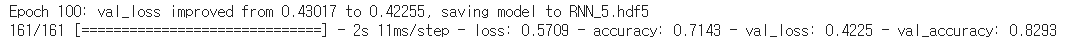